In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

num_classes = 14

model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/drive/MyDrive/dataset/fasterrcnn_resnet50_fpn.pth',map_location='cuda'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
import torch
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transform=None):
        self.coco = CocoDetection(root, annFile)
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.coco[index]

        boxes = []
        labels = []

        for obj in target:
            x,y,w,h = obj['bbox']
            boxes.append([x,y,x+w,y+h])
            labels.append(obj['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.coco)

In [ ]:
def get_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

In [ ]:
train_root = '/content/drive/MyDrive/dataset/train'
train_ann = '/content/drive/MyDrive/dataset/train/_annotations.coco.json'
val_root = '/content/drive/MyDrive/dataset/valid'
val_ann = '/content/drive/MyDrive/dataset/valid/_annotations.coco.json'
test_root = '/content/drive/MyDrive/dataset/test'
test_ann = '/content/drive/MyDrive/dataset/test/_annotations.coco.json'

train_dataset = CocoDataset(train_root, train_ann, transform=get_transform())
val_dataset = CocoDataset(val_root, val_ann, transform=get_transform())
test_dataset = CocoDataset(test_root, test_ann, transform=get_transform())

print(f"Train Samples: {len(train_dataset)}")
print(f"Val Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Train Samples: 2634
Val Samples: 966
Test Samples: 458


In [ ]:
def collate_batch(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch, pin_memory=True)

In [ ]:
from torchvision.ops import box_iou
from tqdm import tqdm
import torch

In [ ]:
import torch
from torchvision.ops import box_iou
from tqdm import tqdm

iou_threshold = 0.5
correct = 0
total = 0

loop = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes']
            labels = output['labels']
            scores = output['scores']

            # Keep predictions with score > 0.5
            mask = scores > 0.5
            pred_boxes = boxes[mask]
            pred_labels = labels[mask]

            target_boxes = targets[i]['boxes']
            target_labels = targets[i]['labels']

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Compute IoU
            iou = box_iou(pred_boxes, target_boxes)  # both are tensors now

            # Count correct predictions: IoU > threshold & matching labels
            max_iou, max_idx = iou.max(dim=1)
            for j in range(len(pred_boxes)):
                if max_iou[j] > iou_threshold and pred_labels[j] == target_labels[max_idx[j]]:
                    correct += 1
                total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct: {correct}")
print(f"Total: {total}")
print(f"IoU-based Accuracy: {accuracy:.4f}")


Testing: 100%|██████████| 115/115 [00:55<00:00,  2.09it/s]

Correct: 4395
Total: 7509
IoU-based Accuracy: 0.5853


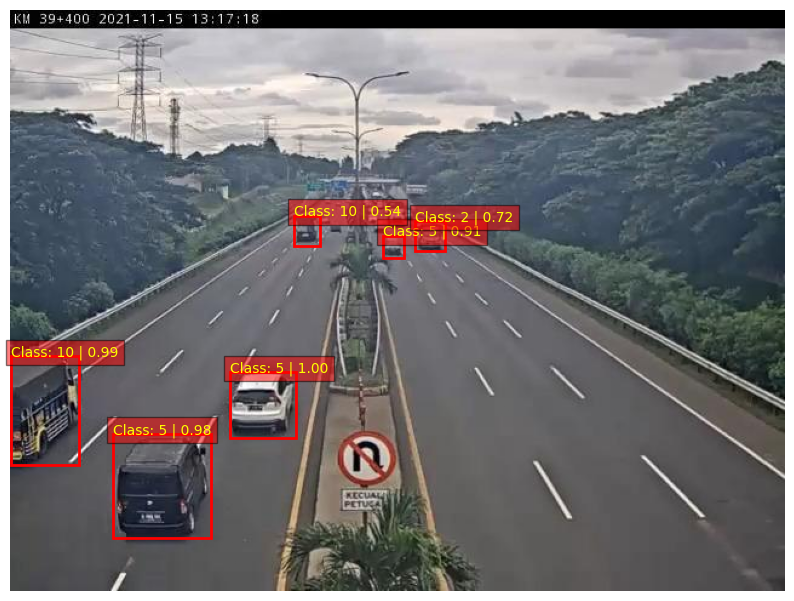

In [ ]:
import matplotlib.pyplot as plt
import torch

model.eval()

images, targets = next(iter(val_loader))

image = images[0].to(device)
target = targets[0]

with torch.no_grad():
    prediction = model([image])[0]

img = image.cpu().permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img)
ax = plt.gca()

# Draw predicted boxes with score > 0.5
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box.cpu()
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=2))
        ax.text(x1, y1, f"Class: {label.item()} | {score:.2f}", color='yellow', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

In [ ]:
# 1. Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# 2. Unfreeze RPN
for param in model.rpn.parameters():
    param.requires_grad = True

# 3. Unfreeze ROI heads
for param in model.roi_heads.parameters():
    param.requires_grad = True

# 4. Unfreeze FPN (all layers)
for param in model.backbone.fpn.parameters():
    param.requires_grad = True

In [ ]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
print(len(params))

30


In [ ]:
import time
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm

# Proper device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


# Enable GradScaler only if CUDA is available
scaler = GradScaler(enabled=torch.cuda.is_available())

num_epochs = 4

for epoch in range(num_epochs):
    print("\n===========================================")
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    print("===========================================\n")

    model.train()

    total_loss = 0
    epoch_start = time.time()

    data_load_time = 0
    forward_time = 0
    backward_time = 0

    loop = tqdm(train_loader)

    for images, targets in loop:
        batch_start = time.time()

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        data_load_time += time.time() - batch_start
        fw_start = time.time()

        # Correct autocast usage
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(losses):
          print("NON-FINITE LOSS DETECTED, stopping training!")
          print("Loss dict:", loss_dict)
          continue

        forward_time += time.time() - fw_start
        bw_start = time.time()

        scaler.scale(losses).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        scaler.step(optimizer)
        scaler.update()

        backward_time += time.time() - bw_start

        total_loss += losses.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=losses.item())

    # ----- END OF EPOCH SUMMARY -----
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(train_loader)

    print("\n-------------------------------------------")
    print(f"Epoch {epoch+1} finished!")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    print(f"  Data Loading: {data_load_time:.2f}s ({data_load_time/epoch_time*100:.1f}%)")
    print(f"  Forward Pass: {forward_time:.2f}s ({forward_time/epoch_time*100:.1f}%)")
    print(f"  Backward Pass: {backward_time:.2f}s ({backward_time/epoch_time*100:.1f}%)")
    print("-------------------------------------------\n")

Using device: cuda

Starting Epoch 1/4



Epoch 1: 100%|██████████| 659/659 [04:37<00:00,  2.37it/s, loss=0.726]



-------------------------------------------
Epoch 1 finished!
Average Loss: 0.5969
Epoch Time: 277.85s
  Data Loading: 1.25s (0.4%)
  Forward Pass: 175.56s (63.2%)
  Backward Pass: 74.49s (26.8%)
-------------------------------------------


Starting Epoch 2/4



Epoch 2: 100%|██████████| 659/659 [04:37<00:00,  2.38it/s, loss=0.502]



-------------------------------------------
Epoch 2 finished!
Average Loss: 0.5614
Epoch Time: 277.08s
  Data Loading: 1.22s (0.4%)
  Forward Pass: 175.26s (63.3%)
  Backward Pass: 74.26s (26.8%)
-------------------------------------------


Starting Epoch 3/4



Epoch 3: 100%|██████████| 659/659 [04:36<00:00,  2.38it/s, loss=0.557]



-------------------------------------------
Epoch 3 finished!
Average Loss: 0.5470
Epoch Time: 276.74s
  Data Loading: 1.23s (0.4%)
  Forward Pass: 175.14s (63.3%)
  Backward Pass: 74.33s (26.9%)
-------------------------------------------


Starting Epoch 4/4



Epoch 4: 100%|██████████| 659/659 [04:36<00:00,  2.38it/s, loss=0.486]


-------------------------------------------
Epoch 4 finished!
Average Loss: 0.5339
Epoch Time: 276.97s
  Data Loading: 1.22s (0.4%)
  Forward Pass: 174.93s (63.2%)
  Backward Pass: 74.53s (26.9%)
-------------------------------------------



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/dataset/fasterrcnn_resnet50_fpn_v2.pth")

In [ ]:
model.eval()

iou_threshold = 0.5
correct = 0
total = 0

loop = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes']
            labels = output['labels']
            scores = output['scores']

            # Keep predictions with score > 0.5
            mask = scores > 0.5
            pred_boxes = boxes[mask]
            pred_labels = labels[mask]

            target_boxes = targets[i]['boxes']
            target_labels = targets[i]['labels']

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Compute IoU
            iou = box_iou(pred_boxes, target_boxes)  # both are tensors now

            # Count correct predictions: IoU > threshold & matching labels
            max_iou, max_idx = iou.max(dim=1)
            for j in range(len(pred_boxes)):
                if max_iou[j] > iou_threshold and pred_labels[j] == target_labels[max_idx[j]]:
                    correct += 1
                total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct: {correct}")
print(f"Total: {total}")
print(f"IoU-based Accuracy: {accuracy:.4f}")

Testing: 100%|██████████| 115/115 [00:56<00:00,  2.02it/s]

Correct: 4356
Total: 7135
IoU-based Accuracy: 0.6105


In [ ]:
num_epochs = 4

for epoch in range(num_epochs):
    print("\n===========================================")
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    print("===========================================\n")

    model.train()

    total_loss = 0
    epoch_start = time.time()

    data_load_time = 0
    forward_time = 0
    backward_time = 0

    loop = tqdm(train_loader)

    for images, targets in loop:
        batch_start = time.time()

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        data_load_time += time.time() - batch_start
        fw_start = time.time()

        # Correct autocast usage
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(losses):
          print("NON-FINITE LOSS DETECTED, stopping training!")
          print("Loss dict:", loss_dict)
          continue

        forward_time += time.time() - fw_start
        bw_start = time.time()

        scaler.scale(losses).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        scaler.step(optimizer)
        scaler.update()

        backward_time += time.time() - bw_start

        total_loss += losses.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=losses.item())

    # ----- END OF EPOCH SUMMARY -----
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(train_loader)

    print("\n-------------------------------------------")
    print(f"Epoch {epoch+1} finished!")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    print(f"  Data Loading: {data_load_time:.2f}s ({data_load_time/epoch_time*100:.1f}%)")
    print(f"  Forward Pass: {forward_time:.2f}s ({forward_time/epoch_time*100:.1f}%)")
    print(f"  Backward Pass: {backward_time:.2f}s ({backward_time/epoch_time*100:.1f}%)")
    print("-------------------------------------------\n")


Starting Epoch 1/4



Epoch 1: 100%|██████████| 659/659 [04:37<00:00,  2.38it/s, loss=0.611]



-------------------------------------------
Epoch 1 finished!
Average Loss: 0.5223
Epoch Time: 277.28s
  Data Loading: 1.23s (0.4%)
  Forward Pass: 174.96s (63.1%)
  Backward Pass: 74.31s (26.8%)
-------------------------------------------


Starting Epoch 2/4



Epoch 2: 100%|██████████| 659/659 [04:37<00:00,  2.37it/s, loss=0.325]



-------------------------------------------
Epoch 2 finished!
Average Loss: 0.5174
Epoch Time: 277.91s
  Data Loading: 1.24s (0.4%)
  Forward Pass: 175.19s (63.0%)
  Backward Pass: 74.75s (26.9%)
-------------------------------------------


Starting Epoch 3/4



Epoch 3: 100%|██████████| 659/659 [04:36<00:00,  2.38it/s, loss=0.352]



-------------------------------------------
Epoch 3 finished!
Average Loss: 0.5093
Epoch Time: 276.91s
  Data Loading: 1.22s (0.4%)
  Forward Pass: 174.82s (63.1%)
  Backward Pass: 74.51s (26.9%)
-------------------------------------------


Starting Epoch 4/4



Epoch 4: 100%|██████████| 659/659 [04:36<00:00,  2.38it/s, loss=0.208]


-------------------------------------------
Epoch 4 finished!
Average Loss: 0.5051
Epoch Time: 276.86s
  Data Loading: 1.22s (0.4%)
  Forward Pass: 174.87s (63.2%)
  Backward Pass: 74.45s (26.9%)
-------------------------------------------



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/dataset/fasterrcnn_resnet50_fpn_v2.pth")

In [ ]:
model.eval()

iou_threshold = 0.5
correct = 0
total = 0

loop = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes']
            labels = output['labels']
            scores = output['scores']

            # Keep predictions with score > 0.5
            mask = scores > 0.5
            pred_boxes = boxes[mask]
            pred_labels = labels[mask]

            target_boxes = targets[i]['boxes']
            target_labels = targets[i]['labels']

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Compute IoU
            iou = box_iou(pred_boxes, target_boxes)  # both are tensors now

            # Count correct predictions: IoU > threshold & matching labels
            max_iou, max_idx = iou.max(dim=1)
            for j in range(len(pred_boxes)):
                if max_iou[j] > iou_threshold and pred_labels[j] == target_labels[max_idx[j]]:
                    correct += 1
                total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct: {correct}")
print(f"Total: {total}")
print(f"IoU-based Accuracy: {accuracy:.4f}")

Testing: 100%|██████████| 115/115 [00:55<00:00,  2.08it/s]

Correct: 4523
Total: 7286
IoU-based Accuracy: 0.6208


In [ ]:
# 1. Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# 2. Unfreeze RPN
for param in model.rpn.parameters():
    param.requires_grad = True

# 3. Unfreeze ROI heads
for param in model.roi_heads.parameters():
    param.requires_grad = True

# 4. Unfreeze FPN (all layers)
for param in model.backbone.fpn.parameters():
    param.requires_grad = True

for name, param in model.backbone.body.named_parameters():
    if "layer4" in name or "layer3" in name:
        param.requires_grad = True

In [ ]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
print(len(params))

59


In [ ]:
import time
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm

# Proper device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


# Enable GradScaler only if CUDA is available
scaler = GradScaler(enabled=torch.cuda.is_available())

num_epochs = 4

for epoch in range(num_epochs):
    print("\n===========================================")
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    print("===========================================\n")

    model.train()

    total_loss = 0
    epoch_start = time.time()

    data_load_time = 0
    forward_time = 0
    backward_time = 0

    loop = tqdm(train_loader)

    for images, targets in loop:
        batch_start = time.time()

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        data_load_time += time.time() - batch_start
        fw_start = time.time()

        # Correct autocast usage
        with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(losses):
          print("NON-FINITE LOSS DETECTED, stopping training!")
          print("Loss dict:", loss_dict)
          continue

        forward_time += time.time() - fw_start
        bw_start = time.time()

        scaler.scale(losses).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        scaler.step(optimizer)
        scaler.update()

        backward_time += time.time() - bw_start

        total_loss += losses.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=losses.item())

    # ----- END OF EPOCH SUMMARY -----
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(train_loader)

    print("\n-------------------------------------------")
    print(f"Epoch {epoch+1} finished!")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    print(f"  Data Loading: {data_load_time:.2f}s ({data_load_time/epoch_time*100:.1f}%)")
    print(f"  Forward Pass: {forward_time:.2f}s ({forward_time/epoch_time*100:.1f}%)")
    print(f"  Backward Pass: {backward_time:.2f}s ({backward_time/epoch_time*100:.1f}%)")
    print("-------------------------------------------\n")

Using device: cuda

Starting Epoch 1/4



Epoch 1: 100%|██████████| 659/659 [05:24<00:00,  2.03it/s, loss=0.528]



-------------------------------------------
Epoch 1 finished!
Average Loss: 0.4884
Epoch Time: 324.29s
  Data Loading: 1.30s (0.4%)
  Forward Pass: 174.87s (53.9%)
  Backward Pass: 119.08s (36.7%)
-------------------------------------------


Starting Epoch 2/4



Epoch 2: 100%|██████████| 659/659 [05:23<00:00,  2.03it/s, loss=0.359]



-------------------------------------------
Epoch 2 finished!
Average Loss: 0.4682
Epoch Time: 323.87s
  Data Loading: 1.29s (0.4%)
  Forward Pass: 174.73s (54.0%)
  Backward Pass: 119.06s (36.8%)
-------------------------------------------


Starting Epoch 3/4



Epoch 3: 100%|██████████| 659/659 [05:23<00:00,  2.04it/s, loss=0.563]



-------------------------------------------
Epoch 3 finished!
Average Loss: 0.4394
Epoch Time: 323.78s
  Data Loading: 1.28s (0.4%)
  Forward Pass: 174.73s (54.0%)
  Backward Pass: 118.89s (36.7%)
-------------------------------------------


Starting Epoch 4/4



Epoch 4: 100%|██████████| 659/659 [05:23<00:00,  2.04it/s, loss=0.385]


-------------------------------------------
Epoch 4 finished!
Average Loss: 0.4166
Epoch Time: 323.64s
  Data Loading: 1.28s (0.4%)
  Forward Pass: 174.41s (53.9%)
  Backward Pass: 119.14s (36.8%)
-------------------------------------------



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/dataset/fasterrcnn_resnet50_fpn_v3.pth")

In [ ]:
model.eval()

iou_threshold = 0.5
correct = 0
total = 0

loop = tqdm(val_loader, desc="Testing")

with torch.no_grad():
    for images, targets in loop:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output['boxes']
            labels = output['labels']
            scores = output['scores']

            # Keep predictions with score > 0.5
            mask = scores > 0.5
            pred_boxes = boxes[mask]
            pred_labels = labels[mask]

            target_boxes = targets[i]['boxes']
            target_labels = targets[i]['labels']

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Compute IoU
            iou = box_iou(pred_boxes, target_boxes)  # both are tensors now

            # Count correct predictions: IoU > threshold & matching labels
            max_iou, max_idx = iou.max(dim=1)
            for j in range(len(pred_boxes)):
                if max_iou[j] > iou_threshold and pred_labels[j] == target_labels[max_idx[j]]:
                    correct += 1
                total += 1

accuracy = correct / total if total > 0 else 0
print(f"Correct: {correct}")
print(f"Total: {total}")
print(f"IoU-based Accuracy: {accuracy:.4f}")

Testing: 100%|██████████| 242/242 [07:35<00:00,  1.88s/it]

Correct: 9651
Total: 14214
IoU-based Accuracy: 0.6790
